In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Import all classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
#Metrics and reports to be used
from sklearn.metrics import confusion_matrix, precision_score,recall_score,mean_absolute_error,f1_score, accuracy_score,roc_curve,auc
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
Cleaned_loan = pd.read_csv('/content/loan_clean-2.csv')

In [3]:
#Normalize the cibil score feature to a max score of 850
Cleaned_loan['capped_credit_score'] = Cleaned_loan['cibil_score'].clip(upper=850)

In [4]:
#Drop the columns not needed after the credit score correction
Cleaned_loan = Cleaned_loan.drop(columns=['cibil_score'])

In [5]:
#Reserve 10% of the data for model deployment testing
loan_clean_10_percent, loan_remaining = train_test_split(Cleaned_loan, test_size=0.90, random_state=30)

In [6]:
#Split the dataset into features (x) and target (y)
x = loan_remaining.drop(['loan_status'],axis=1)
y = loan_remaining['loan_status']
x = x.drop(columns=['loan_id'])

In [7]:
#Load files used to train other models
x_train = pd.read_csv('/content/x_train.csv')
x_test = pd.read_csv('/content/x_test.csv')

y_train = pd.read_csv('/content/y_train.csv')
y_test = pd.read_csv('/content/y_test.csv')

In [8]:
#Normalize the cibil score feature to a max score of 850 and rename the cibil_score to capped_credit_score
x_train['capped_credit_score'] = x_train['cibil_score'].clip(upper=850)
x_test['capped_credit_score'] = x_test['cibil_score'].clip(upper=850)

In [9]:
x_train.columns

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'capped_credit_score'],
      dtype='object')

In [10]:
x_test.columns

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'capped_credit_score'],
      dtype='object')

In [11]:
#Drop the columns not needed after the credit score rename
x_train = x_train.drop(columns=['cibil_score'])
x_test = x_test.drop(columns=['cibil_score'])

In [12]:
#Make a copy for statistical models and for tree & neural network based models
x_train_stats = x_train.copy()
x_test_stats = x_test.copy()

x_train_trees = x_train.copy()
x_test_trees = x_test.copy()

In [13]:
x_train.shape

(2690, 11)

In [14]:
x_test.shape

(1153, 11)

In [15]:
x_test.columns

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'capped_credit_score'],
      dtype='object')

In [16]:
x_train.columns

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'capped_credit_score'],
      dtype='object')

In [17]:
#Feature Selection
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [18]:
#Calculate mutual information for classification use case
mutual_info = mutual_info_classif(x, y)

In [20]:
#Create a DataFrame to see the scores
mi_df = pd.DataFrame({'Feature': x.columns, 'Mutual Information': mutual_info})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

print(mi_df)

                     Feature  Mutual Information
10       capped_credit_score            0.503629
2              self_employed            0.014863
5                  loan_term            0.009296
8        luxury_assets_value            0.004796
1                  education            0.004357
4                loan_amount            0.002156
0           no_of_dependents            0.000152
3               income_annum            0.000000
6   residential_assets_value            0.000000
7    commercial_assets_value            0.000000
9           bank_asset_value            0.000000


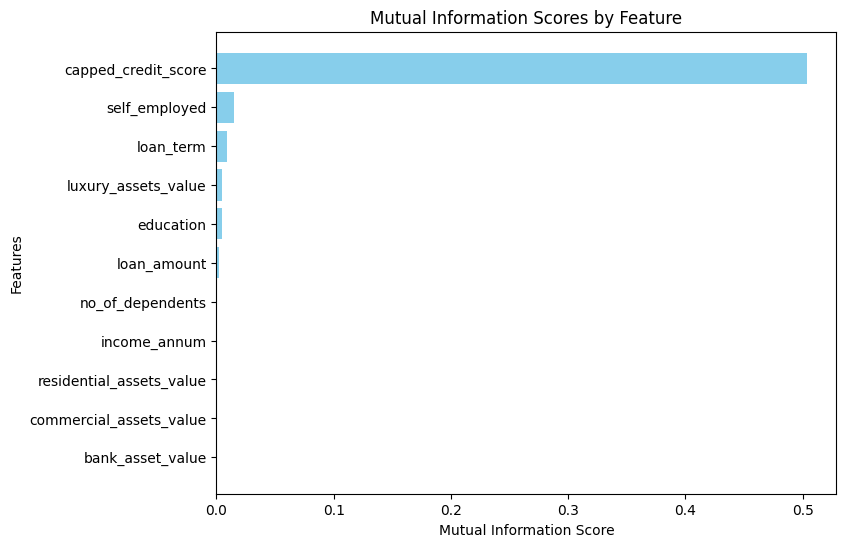

In [21]:
# Plotting the mutual information scores
plt.figure(figsize=(8, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information Scores by Feature')
plt.gca().invert_yaxis()  # To have the highest score on top
plt.show()

In [22]:
#Select the top k features (e.g., top 5 features)
selector = SelectKBest(mutual_info_classif, k=5)
x_new = selector.fit_transform(x, y)

#Display the selected features
selected_features = selector.get_support(indices=True)
print(x.columns[selected_features])

Index(['self_employed', 'loan_amount', 'loan_term', 'luxury_assets_value',
       'capped_credit_score'],
      dtype='object')


In [23]:
y_test.shape

(1153, 1)

In [25]:
x_train.shape

(2690, 11)

In [24]:
warnings.filterwarnings("ignore")

In [26]:
#Scale independent features using standard scaler
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
x_train_stats_scaled = pd.DataFrame(scale.fit_transform(x_train_stats), columns = x_train_stats.columns)
x_test_stats_scaled = pd.DataFrame(scale.transform(x_test_stats), columns = x_test_stats.columns)

In [27]:
#Create model objects to be used for classification
Log_reg = LogisticRegression()
RF = RandomForestClassifier()
XGBoost = xgb.XGBClassifier()
SVC = LinearSVC()
MLP = MLPClassifier(random_state=30)
ADA = AdaBoostClassifier()
LGBM = LGBMClassifier()

models = [Log_reg, SVC, RF, XGBoost, ADA, LGBM, MLP]


#Create an empty lists to store the recall and precision scores for later
recall_scores_train = []
recall_scores_test = []
precision_scores_train = []
precision_scores_test = []


for model in models:
  if (model == Log_reg) | (model == SVC):
    model.fit(x_train_stats_scaled, y_train)

#Predictions and evaluations for the training set
#Test recall and precision for stats models
    y_train_pred = model.predict(x_train_stats_scaled)
    recall_train = recall_score(y_train, y_train_pred)
    recall_scores_train.append(recall_train)
    precision_train = precision_score(y_train, y_train_pred)
    precision_scores_train.append(precision_train)

#Predictions and evaluations for the test set
    y_test_pred = model.predict(x_test_stats_scaled)
    recall_test = recall_score(y_test, y_test_pred)
    recall_scores_test.append(recall_test)
    precision_test = precision_score(y_test, y_test_pred)
    precision_scores_test.append(precision_test)




  else:
    model.fit(x_train_trees, y_train)
    y_train_pred = model.predict(x_train_trees)
    recall_train = recall_score(y_train, y_train_pred)
    recall_scores_train.append(recall_train)
    precision_train = precision_score(y_train, y_train_pred)
    precision_scores_train.append(precision_train)


#Test recall and precision for tree and NN models
    y_test_pred = model.predict(x_test_trees)
    recall_test = recall_score(y_test, y_test_pred)
    recall_scores_test.append(recall_test)
    precision_test = precision_score(y_test, y_test_pred)
    precision_scores_test.append(precision_test)

[LightGBM] [Info] Number of positive: 1674, number of negative: 1016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 2690, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622305 -> initscore=0.499343
[LightGBM] [Info] Start training from score 0.499343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [28]:
pd.DataFrame({'Recall_Train': recall_scores_train, 'Recall_Test': recall_scores_test, 'Precision_Train': precision_scores_train, 'Precision_Test': precision_scores_test },
             index = ['Logistic Regression','Support Vector Machine', 'Random Forest', 'XGBoost', 'ADABoost',
                      'LGBM', 'MLP'])

,Recall_Train,Recall_Test,Precision_Train,Precision_Test
Logistic Regression,0.936081,0.931660,0.934964,0.932961
Support Vector Machine,0.934886,0.928870,0.937126,0.931469
Random Forest,1.000000,0.983264,1.000000,0.983264
XGBoost,1.000000,0.988842,1.000000,0.983356
ADABoost,0.978495,0.980474,0.978495,0.983217
LGBM,1.000000,0.986053,1.000000,0.977870
MLP,0.403226,0.415621,0.643470,0.652079


In [29]:
def pred_pipeline(model_pred, x_train_stats, x_test_stats, y_train, y_test):
    model_pred.fit(x_train_stats, y_train)

    if isinstance(model_pred, (LogisticRegression, LinearSVC)):
        x_test = x_test_stats
    else:
        x_test = x_test_trees

    y_test_pred = model_pred.predict(x_test)
    train_accuracy = model_pred.score(x_test, y_test)

    print("Cross Validation Score of", model_pred.__class__.__name__, "=", np.mean(cross_val_score(model_pred, x_train_stats, y_train, cv=5)), "\n")
    print("Training Accuracy:", train_accuracy)

    #F1-SCORE
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print("F1 Score of", model_pred.__class__.__name__, "=", f1, "\n")

    #MAE
    mae = mean_absolute_error(y_test, y_test_pred)
    print("Mean Absolute Error (MAE) of", model_pred.__class__.__name__, "=", mae, "\n")

    #Confusion Matrix
    c_matrix = confusion_matrix(y_test, y_test_pred)
    c_matrix_hm = sns.heatmap(c_matrix, annot=True, fmt='g', cmap='Blues')
    c_matrix_hm.set_xlabel("Predicted", labelpad=20)
    c_matrix_hm.set_ylabel("Actual", labelpad=20)
    plt.show()



# Compute predicted probabilities and ROC AUC only if applicable
    if hasattr(model_pred, "predict_proba"):
        y_test_prob = model_pred.predict_proba(x_test)[:, 1]  # Get probability for the positive class

        # ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC')
        plt.legend(loc="lower right")
        plt.show()

    else:
        print("Model does not support probability prediction, skipping AUC ROC curve generation.")




Cross Validation Score of LogisticRegression = 0.9185873605947956 

Training Accuracy: 0.9158716392020815
F1 Score of LogisticRegression = 0.9158904687556845 

Mean Absolute Error (MAE) of LogisticRegression = 0.08412836079791847 



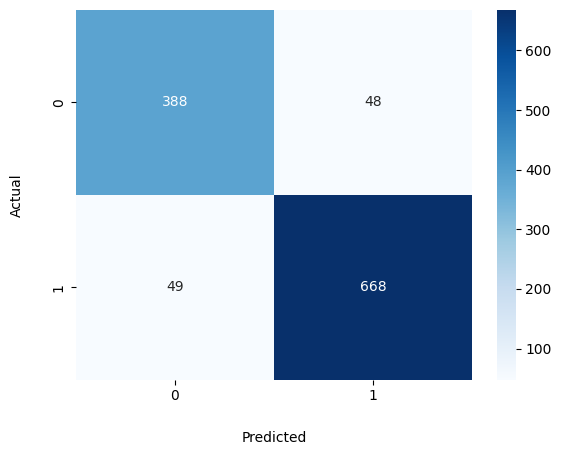

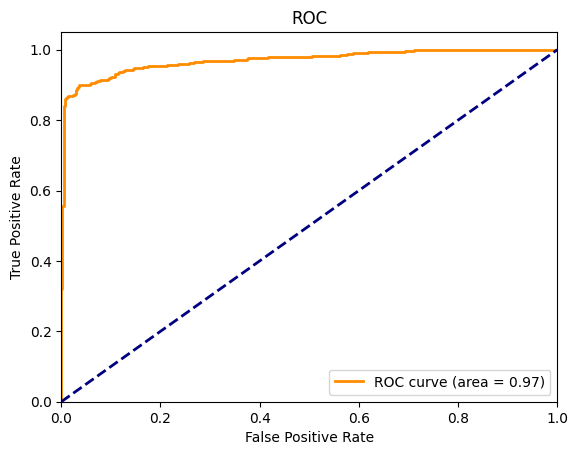

In [30]:
# Example usage with Logistic Regression
model_pred = Log_reg
pred_pipeline(model_pred, x_train_stats_scaled, x_test_stats_scaled, y_train, y_test)

Cross Validation Score of LinearSVC = 0.9189591078066914 

Training Accuracy: 0.9132697311361665
F1 Score of LinearSVC = 0.9133083990231899 

Mean Absolute Error (MAE) of LinearSVC = 0.08673026886383348 



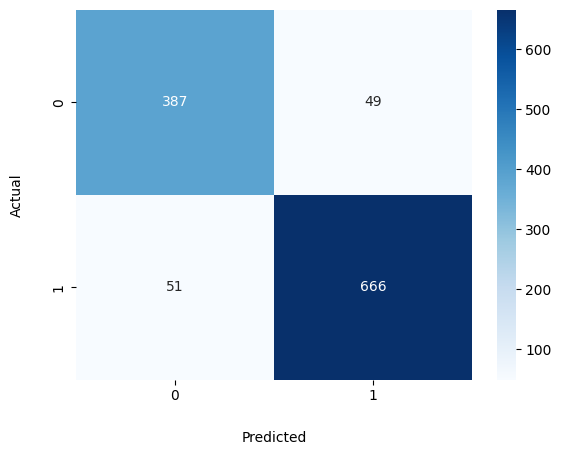

Model does not support probability prediction, skipping AUC ROC curve generation.


In [31]:
# Example usage with SVC
model_pred = SVC
pred_pipeline(model_pred, x_train_stats_scaled, x_test_stats_scaled, y_train, y_test)

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@ tree and NN based models @@@@@@@@@@@@@@@@@

Cross Validation Score of RandomForestClassifier = 0.9750929368029739 

Training Accuracy: 0.9809193408499567
F1 Score of RandomForestClassifier = 0.9809193408499567 

Mean Absolute Error (MAE) of RandomForestClassifier = 0.019080659150043366 



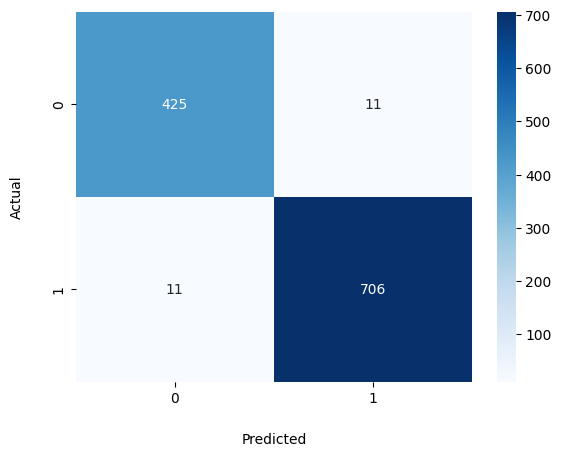

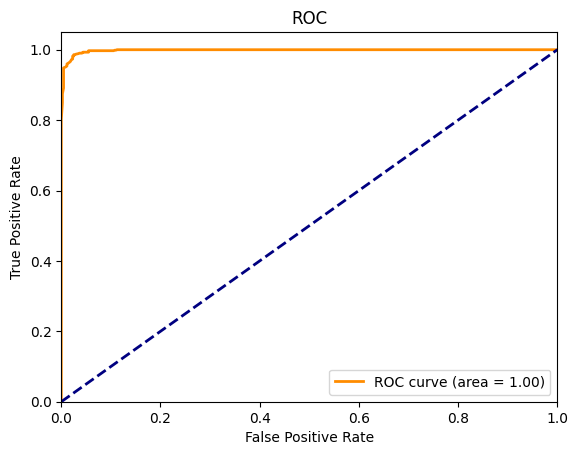

In [32]:
#Random Forest model
model_pred = RF
pred_pipeline(model_pred, x_train, x_test_trees, y_train, y_test)

Cross Validation Score of XGBClassifier = 0.9795539033457249 

Training Accuracy: 0.9826539462272333
F1 Score of XGBClassifier = 0.9826381036100383 

Mean Absolute Error (MAE) of XGBClassifier = 0.017346053772766695 



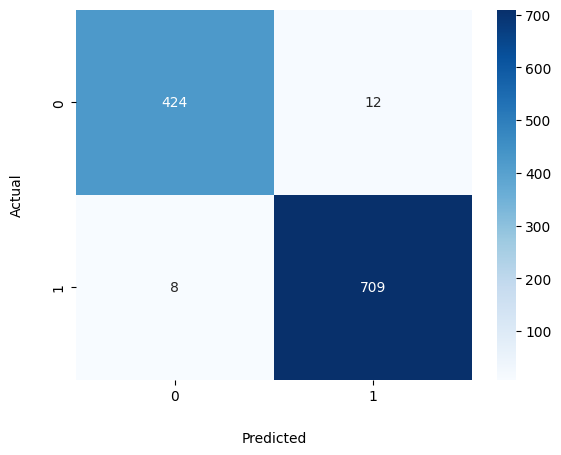

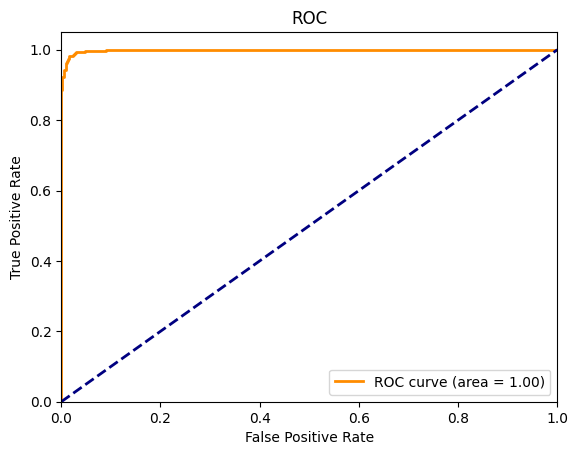

In [33]:
#XGBOOST model
model_pred = XGBoost
pred_pipeline(model_pred, x_train, x_test_trees, y_train, y_test)

Cross Validation Score of AdaBoostClassifier = 0.962825278810409 

Training Accuracy: 0.9774501300954033
F1 Score of AdaBoostClassifier = 0.9774601837460292 

Mean Absolute Error (MAE) of AdaBoostClassifier = 0.022549869904596703 



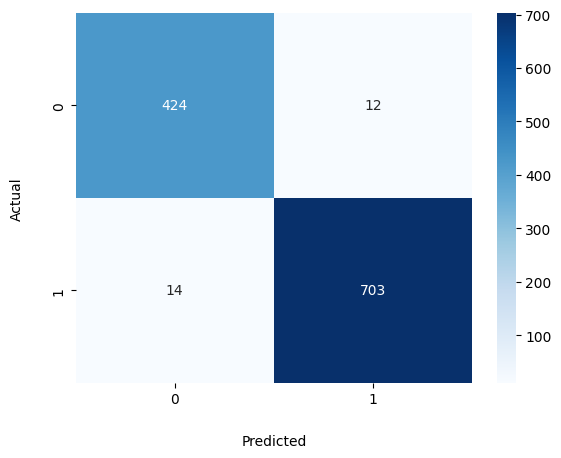

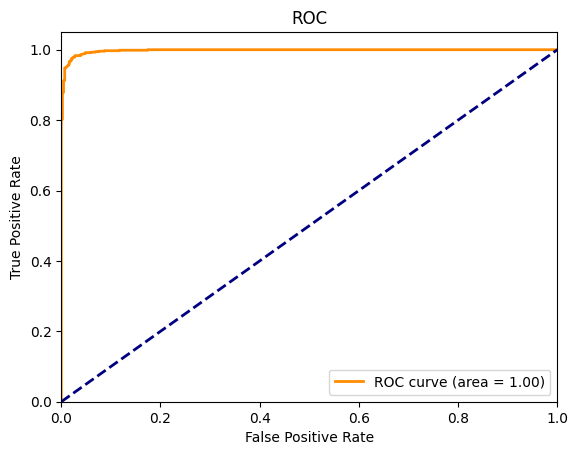

In [34]:
#ADABoost model
model_pred = ADA
pred_pipeline(model_pred, x_train, x_test_trees, y_train, y_test)

[LightGBM] [Info] Number of positive: 1674, number of negative: 1016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 2690, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622305 -> initscore=0.499343
[LightGBM] [Info] Start training from score 0.499343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

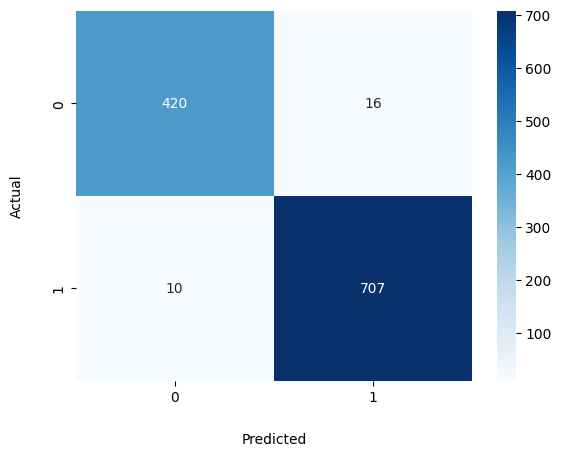

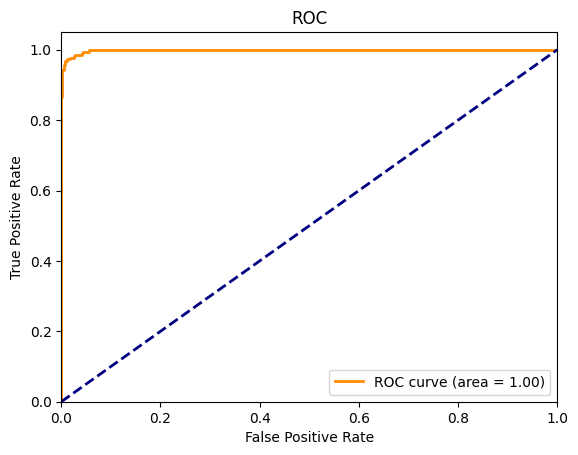

In [35]:
#LGBM model
model_pred = LGBM
pred_pipeline(model_pred, x_train, x_test_trees, y_train, y_test)

In [ ]:
print(LGBM)

LGBMClassifier()


Cross Validation Score of MLPClassifier = 0.5197026022304833 

Training Accuracy: 0.4986990459670425
F1 Score of MLPClassifier = 0.5007586164074292 

Mean Absolute Error (MAE) of MLPClassifier = 0.5013009540329575 



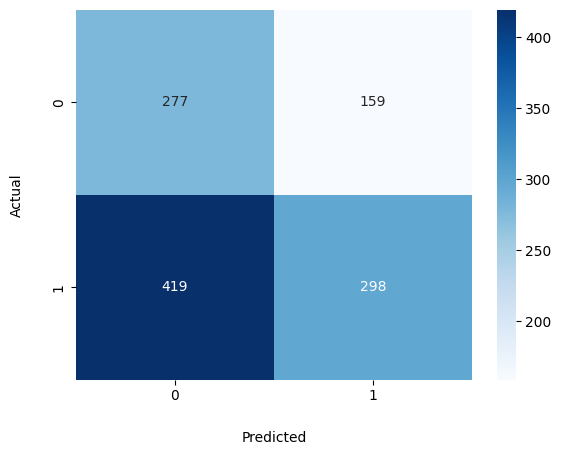

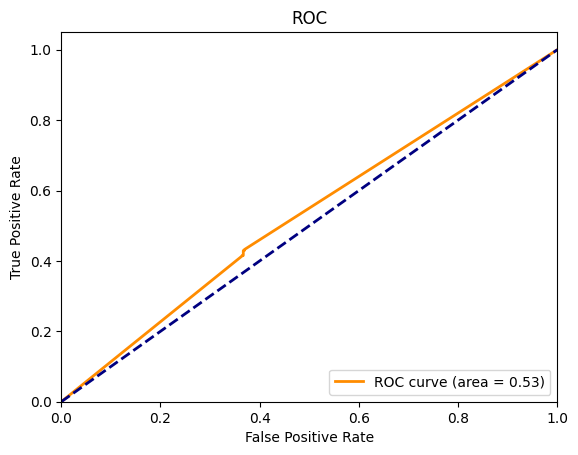

In [36]:
#MLP neural network model
model_pred = MLP
pred_pipeline(model_pred, x_train, x_test_trees, y_train, y_test)

In [ ]:
print(MLP)

MLPClassifier(random_state=30)


In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@GRIDSEARCH@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
#Tune stats models then tree-based models

In [37]:
#Import libraries
from ast import Param
from sklearn.model_selection import GridSearchCV

In [ ]:
#Tune models using GridSearch
#Tune for Logistic Regression
param = {
    'penalty': ['l1','l2'],
    'C': [0.01, 0.1, 0.2],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced'],
    'max_iter': [50, 100, 500, 1000]
}

Log_reg_tuned = GridSearchCV(estimator= Log_reg, param_grid= param, cv = 5, scoring = 'recall')
Log_reg_tuned.fit(x_train_stats,y_train)
best_Log_reg = Log_reg_tuned.best_estimator_
print(Log_reg_tuned.best_params_)

{'C': 0.2, 'class_weight': 'balanced', 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
#Using best parameters from GRidsearch for Log_reg
#Logistic Regression model

In [ ]:
#Tune models using GridSearch
#Tune for Support Vector Machine
param = {
    'C': [0.01, 0.1, 0.2, 1.0],
    'class_weight': ['balanced'],
    'max_iter': [1000, 1500, 2000]
}

SVC_tuned = GridSearchCV(estimator= SVC, param_grid= param, cv = 5, scoring = 'recall')
SVC_tuned.fit(x_train_stats,y_train)
best_SVC = SVC_tuned.best_estimator_
print(SVC_tuned.best_params_)

{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}


In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@ GRIDSEARCH FOR TREE and NN BASED MODELS @@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
#Tune models using GridSearch
#Tune for Random Forest (RF)
param = {
    'n_estimators': [100, 250, 500],
    'criterion': ['gini', 'entropy'], #measure the quality of a split.
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [25, 50, 75],
    'min_samples_split': [75, 150, 225]
}

RF_tuned = GridSearchCV(estimator= RF, param_grid= param, cv = 5, scoring = 'recall', n_jobs=-1)
RF_tuned.fit(x_train_trees,y_train)
best_RF = RF_tuned.best_estimator_
print(RF_tuned.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 25, 'min_samples_split': 150, 'n_estimators': 100}


In [ ]:
#Tune models using GridSearch
#Tune for XGBoost
param = {
    'learning_rate': [0.01, 0.1, 0.2],
    'min_split_loss': [0, 100, 500, 1000],  # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
    'tree_method': ['exact', 'hist', 'approx'],
    'max_depth': [10, 20, 30],
    'booster': ['gbtree', 'dart'],
    'objective': ['binary:hinge']
}

XGBoost_tuned = GridSearchCV(estimator= XGBoost, param_grid= param, cv = 5, scoring = 'recall')
XGBoost_tuned.fit(x_train_trees,y_train)
best_XGBoost = XGBoost_tuned.best_estimator_
print(XGBoost_tuned.best_params_)

{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 10, 'min_split_loss': 0, 'objective': 'binary:hinge', 'tree_method': 'exact'}


In [ ]:
#Tune models using GridSearch
#Tune for ADA Boost
param = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2]

}

ADA_tuned = GridSearchCV(estimator= ADA, param_grid= param, cv = 5, scoring = 'recall')
ADA_tuned.fit(x_train_trees,y_train)
best_ADA = ADA_tuned.best_estimator_
print(ADA_tuned.best_params_)

{'learning_rate': 0.2, 'n_estimators': 500}


In [ ]:
#Tune for LGBM
param = {
    'num_leaves': [50, 100, 150],
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators': [100, 200, 400],
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': [-1]
}

LGBM_tuned = GridSearchCV(estimator= LGBM, param_grid= param, cv = 5, scoring = 'recall')
LGBM_tuned.fit(x_train_trees,y_train)
best_LGBM = LGBM_tuned.best_estimator_
print(LGBM_tuned.best_params_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
#Tune for MLP
param = {
    'hidden_layer_sizes': [(100,), (150,), (200,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300, 500]
}

MLP_tuned = GridSearchCV(estimator= MLP, param_grid= param, cv = 5, scoring = 'recall')
MLP_tuned.fit(x_train_trees,y_train)
best_MLP = MLP_tuned.best_estimator_
print(MLP_tuned.best_params_)

{'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}


In [38]:
#Re-run with tuned models and observe performance outcome
#create model objects to be used for classification of the tuned models using best hyperparameters
tuned_Log_reg = LogisticRegression(C= 0.2, class_weight= 'balanced', max_iter= 50, penalty= 'l1', solver= 'liblinear')
tuned_SVC = LinearSVC(C= 0.1, class_weight= 'balanced', max_iter= 1000)
tuned_RF = RandomForestClassifier(criterion= 'gini', max_depth= 6, max_features= 'sqrt', min_samples_leaf= 25, min_samples_split= 150, n_estimators= 100)
tuned_XGBoost = xgb.XGBClassifier(boosting_type= 'gbtree', learning_rate= 0.01, max_depth= 10, min_split_loss= 0, objective= 'binary:hinge', tree_method= 'exact')
tuned_ADA = AdaBoostClassifier(learning_rate= 0.2, n_estimators= 500)
tuned_LGBM = LGBMClassifier(boosting_type= 'dart', learning_rate= 0.2, max_depth= -1, n_estimators= 400, num_leaves= 100)
tuned_MLP = MLPClassifier(activation= 'logistic', hidden_layer_sizes= (100,), learning_rate= 'constant', learning_rate_init= 0.001, max_iter= 200, solver= 'sgd', random_state=30)

models_tuned = [tuned_Log_reg, tuned_SVC,tuned_RF, tuned_XGBoost, tuned_ADA, tuned_LGBM, tuned_MLP]


#create empty lists to store the omodel output for later
recall_scores_train_tuned = []
recall_scores_test_tuned = []
precision_scores_train_tuned = []
precision_scores_test_tuned = []


for model in models_tuned:
  if (model == tuned_Log_reg) | (model == tuned_SVC):
    model.fit(x_train_stats_scaled, y_train)

#Predictions and evaluations for the training set
    y_train_pred = model.predict(x_train_stats_scaled)
    recall_train = recall_score(y_train, y_train_pred)
    recall_scores_train_tuned.append(recall_train)
    precision_train = precision_score(y_train, y_train_pred)
    precision_scores_train_tuned.append(precision_train)


    y_test_pred = model.predict(x_test_stats_scaled)
    recall_test = recall_score(y_test, y_test_pred)
    recall_scores_test_tuned.append(recall_test)
    precision_test = precision_score(y_test, y_test_pred)
    precision_scores_test.append(precision_test)



  else:
    model.fit(x_train_trees, y_train)
    y_train_pred = model.predict(x_train_trees)
    recall_train = recall_score(y_train, y_train_pred)
    recall_scores_train_tuned.append(recall_train)
    precision_train = precision_score(y_train, y_train_pred)
    precision_scores_train_tuned.append(precision_train)

    y_test_pred = model.predict(x_test_trees)
    recall_test = recall_score(y_test, y_test_pred)
    recall_scores_test_tuned.append(recall_test)
    precision_test = precision_score(y_test, y_test_pred)
    precision_scores_test_tuned.append(precision_test)

[LightGBM] [Info] Number of positive: 1674, number of negative: 1016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 2690, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622305 -> initscore=0.499343
[LightGBM] [Info] Start training from score 0.499343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [39]:
pd.DataFrame({
    'Recall_Train_Original': recall_scores_train,
    'Recall_Test_Original': recall_scores_test,
    'Recall_Train_Tuned': recall_scores_train_tuned,
    'Recall_Test_Tuned': recall_scores_test_tuned
}, index=['Logistic Regression','Support Vector Machine', 'Random Forest', 'XGBoost', 'ADABoost',
           'LGBM', 'MLP'])

,Recall_Train_Original,Recall_Test_Original,Recall_Train_Tuned,Recall_Test_Tuned
Logistic Regression,0.936081,0.931660,0.908005,0.910739
Support Vector Machine,0.934886,0.928870,0.903226,0.900976
Random Forest,1.000000,0.983264,0.958184,0.945607
XGBoost,1.000000,0.988842,1.000000,1.000000
ADABoost,0.978495,0.980474,0.977300,0.977685
LGBM,1.000000,0.986053,1.000000,0.984658
MLP,0.403226,0.415621,1.000000,1.000000


In [40]:
from google.colab import files
import pickle

In [ ]:
#download models
#Save using pickle
pickle.dump(tuned_LGBM, open('/content/tuned_LGBM.pkl', 'wb'))
pickle.dump(tuned_XGBoost, open('/content/tuned_XGBoost.pkl', 'wb'))
pickle.dump(tuned_RF, open('/content/tuned_RF.pkl', 'wb'))
pickle.dump(LGBM, open('/content/LGBM.pkl', 'wb'))

In [ ]:
#download best perfoming untuned model
#Save using pickle
pickle.dump(XGBoost, open('/content/XGBoost.pkl', 'wb'))
pickle.dump(LGBM, open('/content/LGBM.pkl', 'wb'))

In [41]:
#Look at the feature imporatnce that contributed to that performance by tuned_LGBM
feature_importance = LGBM.feature_importances_

#Sort feature
indices = sorted(range(len(feature_importance)),key=lambda k: feature_importance[k], reverse=True)

#print features
print("Feature Importance Ranking:")
for i, index in enumerate(indices):
  print(f"{x_train_trees.columns[index]}: {round(feature_importance[index], 3)}")

Feature Importance Ranking:
loan_amount: 689
capped_credit_score: 626
residential_assets_value: 369
income_annum: 349
commercial_assets_value: 255
luxury_assets_value: 224
loan_term: 160
no_of_dependents: 114
bank_asset_value: 108
self_employed: 22
education: 19


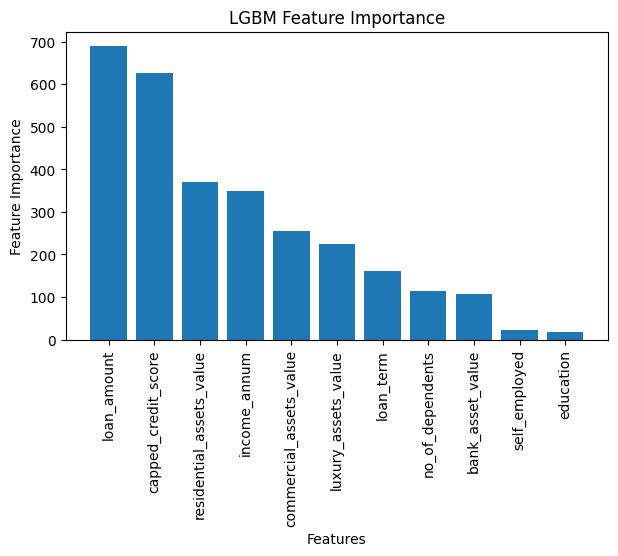

In [42]:
#Plot feature importance
plt.figure(figsize= (7, 4))
plt.bar(range(len(feature_importance)), feature_importance[indices], align="center")
plt.xticks(range(len(feature_importance)), [x_train_trees.columns[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("LGBM Feature Importance")

plt.show()

[LightGBM] [Info] Number of positive: 1674, number of negative: 1016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 2690, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622305 -> initscore=0.499343
[LightGBM] [Info] Start training from score 0.499343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

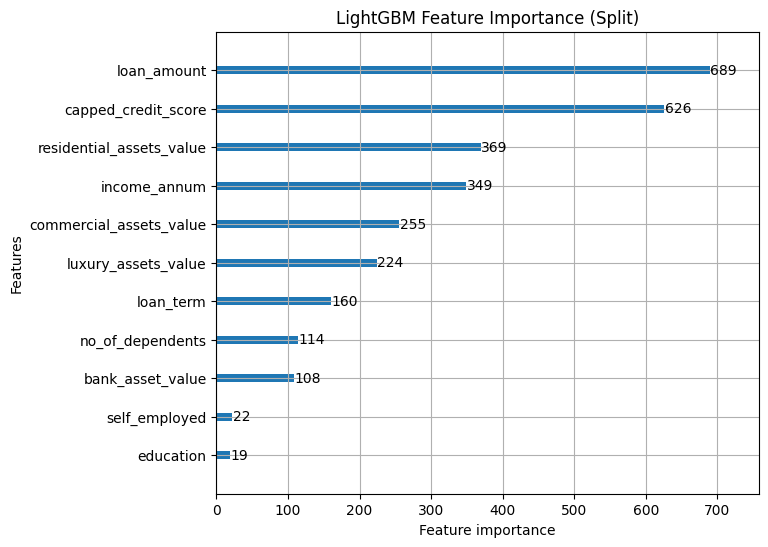

In [43]:
import lightgbm as lgb
LGBM_split = lgb.LGBMClassifier().fit(x_train_trees, y_train)
# Plot feature importance using Split
lgb.plot_importance(LGBM_split, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

[LightGBM] [Info] Number of positive: 1674, number of negative: 1016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 2690, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622305 -> initscore=0.499343
[LightGBM] [Info] Start training from score 0.499343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

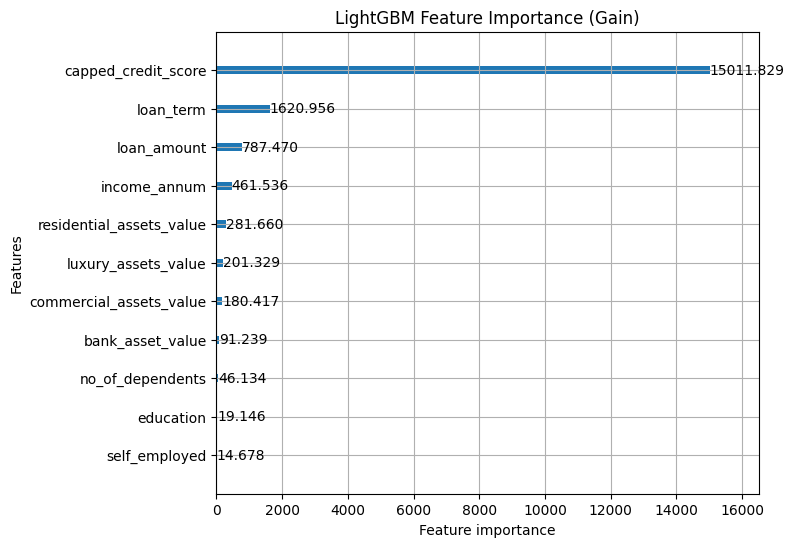

In [44]:
#Plot feature importance using Gain
LGBM_gain = lgb.LGBMClassifier().fit(x_train_trees, y_train)
lgb.plot_importance(LGBM_gain, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [45]:
#Look at the feature imporatnce that contributed to that performance by tuned_LGBM
feature_importance = tuned_LGBM.feature_importances_

#Sort feature
indices = sorted(range(len(feature_importance)),key=lambda k: feature_importance[k], reverse=True)

#print features
print("Feature Importance Ranking:")
for i, index in enumerate(indices):
  print(f"{x_train_trees.columns[index]}: {round(feature_importance[index], 3)}")

Feature Importance Ranking:
loan_amount: 4643
capped_credit_score: 3874
residential_assets_value: 3100
income_annum: 3075
luxury_assets_value: 2588
commercial_assets_value: 2134
loan_term: 1680
bank_asset_value: 1291
no_of_dependents: 969
self_employed: 192
education: 166


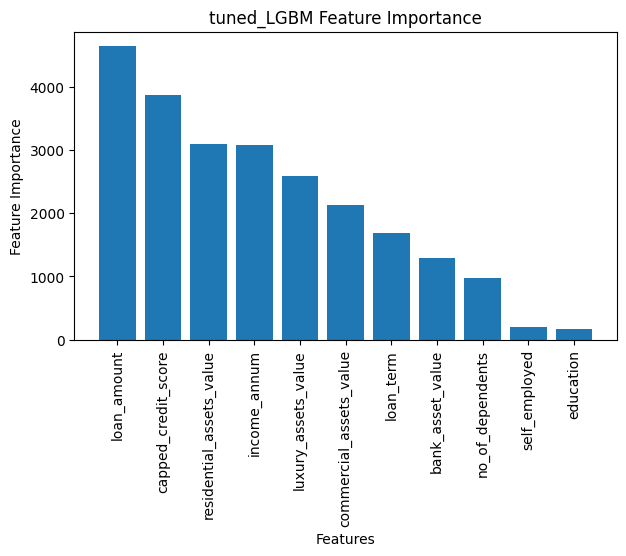

In [46]:
#Plot feature importance
plt.figure(figsize= (7, 4))
plt.bar(range(len(feature_importance)), feature_importance[indices], align="center")
plt.xticks(range(len(feature_importance)), [x_train_trees.columns[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("tuned_LGBM Feature Importance")

plt.show()

In [47]:
#Look at the feature imporatnce that contributed to that performance by (XGBoost)
feature_importance = XGBoost.feature_importances_

#Sort feature
indices = sorted(range(len(feature_importance)),key=lambda k: feature_importance[k], reverse=True)

#print features
print("Feature Importance Ranking:")
for i, index in enumerate(indices):
  print(f"{x_train_trees.columns[index]}: {round(feature_importance[index], 3)}")

Feature Importance Ranking:
capped_credit_score: 0.6259999871253967
loan_term: 0.2409999966621399
loan_amount: 0.028999999165534973
income_annum: 0.020999999716877937
luxury_assets_value: 0.01899999938905239
residential_assets_value: 0.01600000075995922
commercial_assets_value: 0.014000000432133675
bank_asset_value: 0.009999999776482582
education: 0.008999999612569809
self_employed: 0.007000000216066837
no_of_dependents: 0.007000000216066837


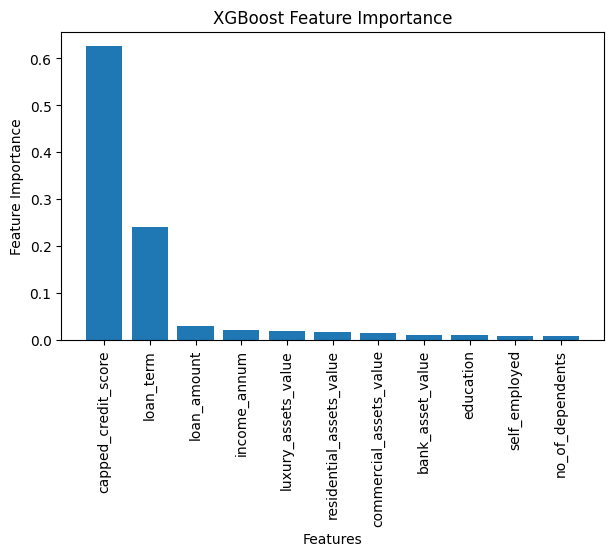

In [48]:
#Plot feature importance
plt.figure(figsize= (7, 4))
plt.bar(range(len(feature_importance)), feature_importance[indices], align="center")
plt.xticks(range(len(feature_importance)), [x_train_trees.columns[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("XGBoost Feature Importance")

plt.show()

In [49]:
#Look at the feature imporatnce that contributed to that performance by (LGBM)
feature_importance = ADA.feature_importances_

#Sort feature
indices = sorted(range(len(feature_importance)),key=lambda k: feature_importance[k], reverse=True)

#print features
print("Feature Importance Ranking:")
for i, index in enumerate(indices):
  print(f"{x_train_trees.columns[index]}: {round(feature_importance[index], 3)}")

Feature Importance Ranking:
capped_credit_score: 0.34
loan_amount: 0.16
loan_term: 0.12
bank_asset_value: 0.1
income_annum: 0.06
residential_assets_value: 0.06
commercial_assets_value: 0.06
luxury_assets_value: 0.06
no_of_dependents: 0.02
education: 0.02
self_employed: 0.0


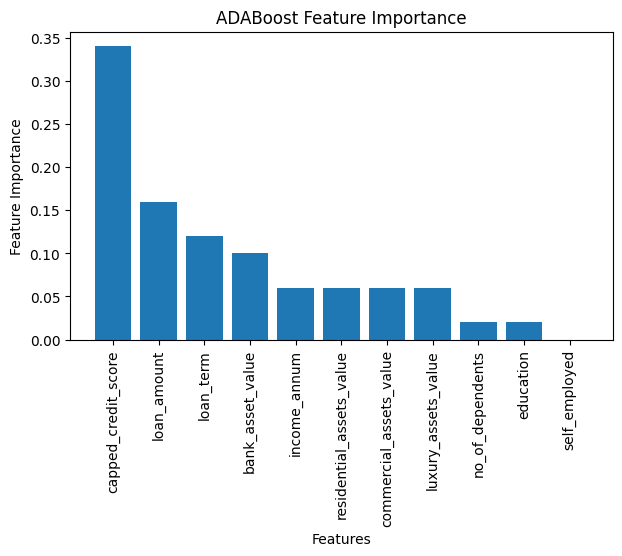

In [50]:
#Plot feature importance
plt.figure(figsize= (7, 4))
plt.bar(range(len(feature_importance)), feature_importance[indices], align="center")
plt.xticks(range(len(feature_importance)), [x_train_trees.columns[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("ADABoost Feature Importance")

plt.show()

In [51]:
#Look at the feature imporatnce that contributed to that performance by (Random Forest)
feature_importance = RF.feature_importances_

#Sort feature
indices = sorted(range(len(feature_importance)),key=lambda k: feature_importance[k], reverse=True)

#print features
print("Feature Importance Ranking:")
for i, index in enumerate(indices):
  print(f"{x_train_trees.columns[index]}: {round(feature_importance[index], 3)}")

Feature Importance Ranking:
capped_credit_score: 0.807
loan_term: 0.057
loan_amount: 0.029
residential_assets_value: 0.02
commercial_assets_value: 0.019
luxury_assets_value: 0.019
income_annum: 0.018
bank_asset_value: 0.016
no_of_dependents: 0.009
self_employed: 0.003
education: 0.003


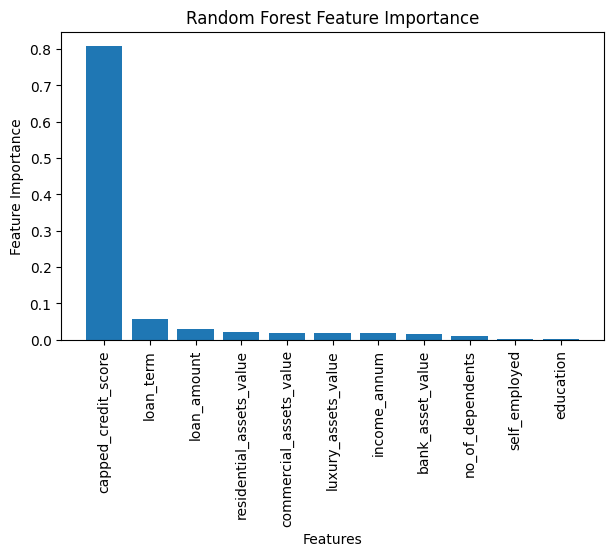

In [52]:
#Plot feature importance
plt.figure(figsize= (7, 4))
plt.bar(range(len(feature_importance)), feature_importance[indices], align="center")
plt.xticks(range(len(feature_importance)), [x_train_trees.columns[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")

plt.show()

In [53]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.2 MB/s eta 0:00:00


In [54]:
#import libraries for shap
import shap
shap.initjs()
%matplotlib inline

In [55]:
#get shap values
explainer = shap.Explainer(LGBM)
shap_values = explainer(x_train_trees)

In [56]:
np.shape(shap_values.values)

(2690, 11)

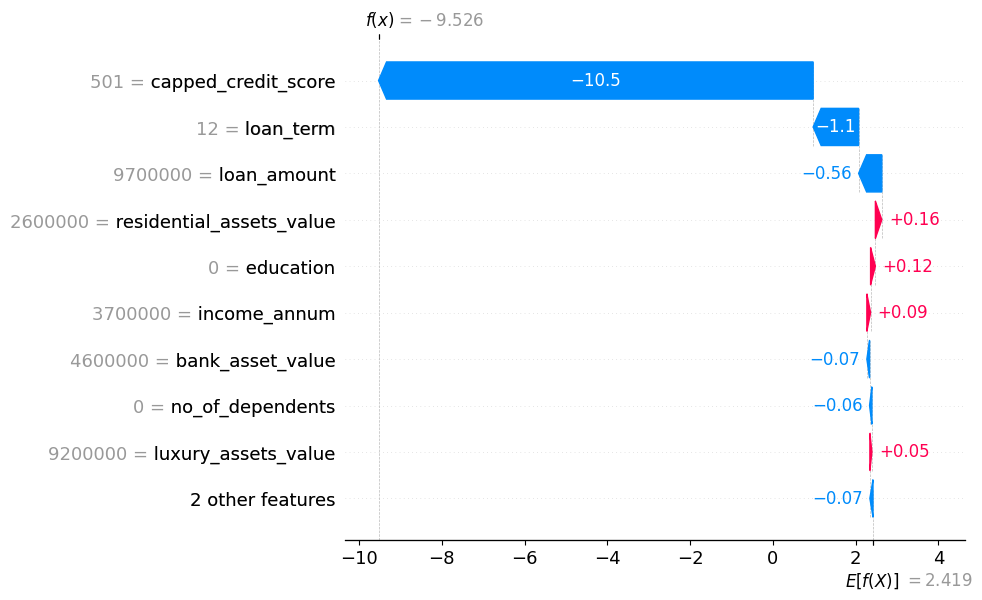

In [57]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[0])

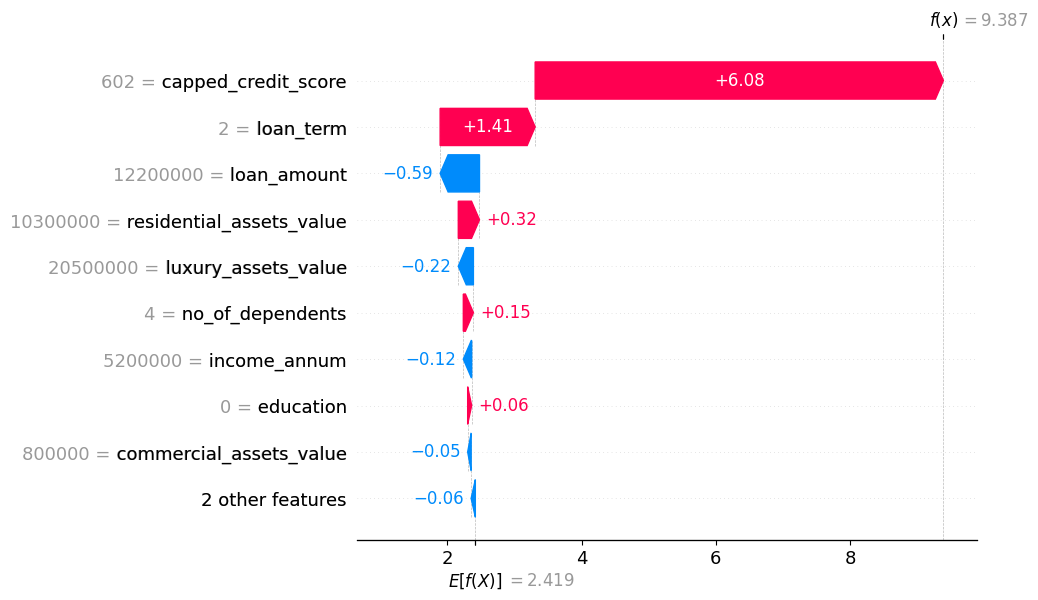

In [58]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[100])

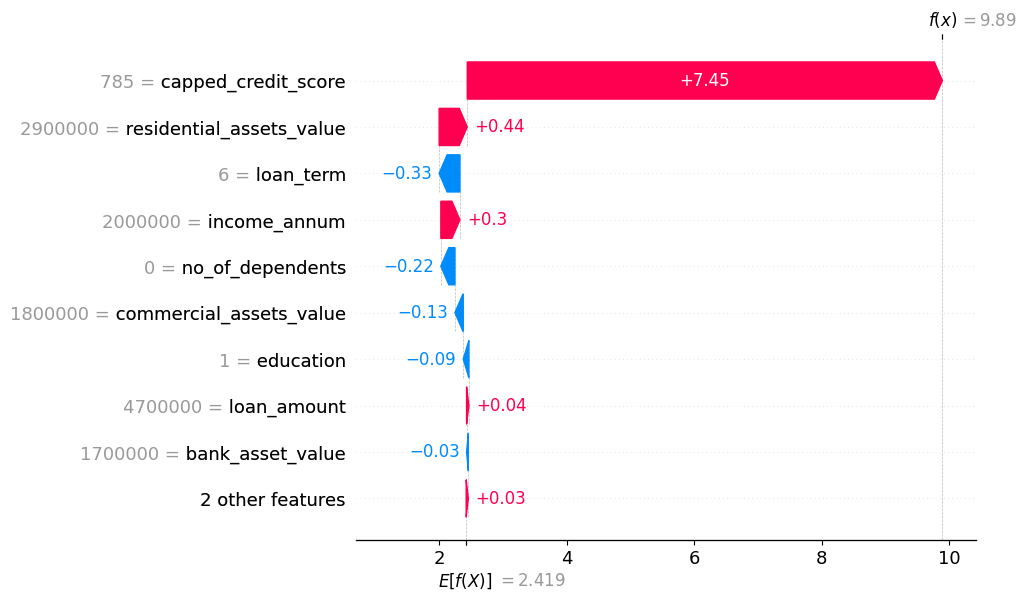

In [59]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[300])

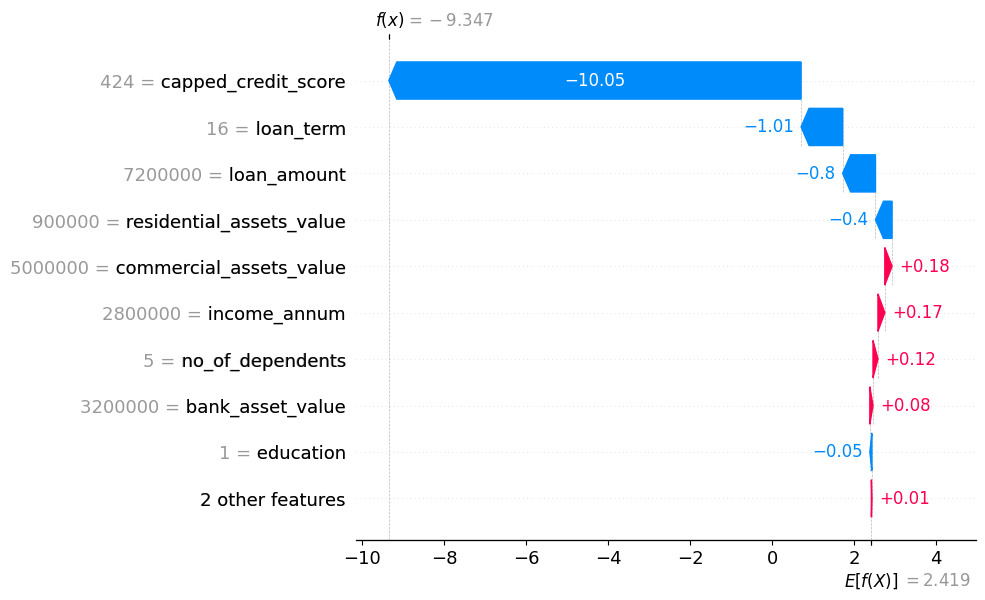

In [60]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[4])

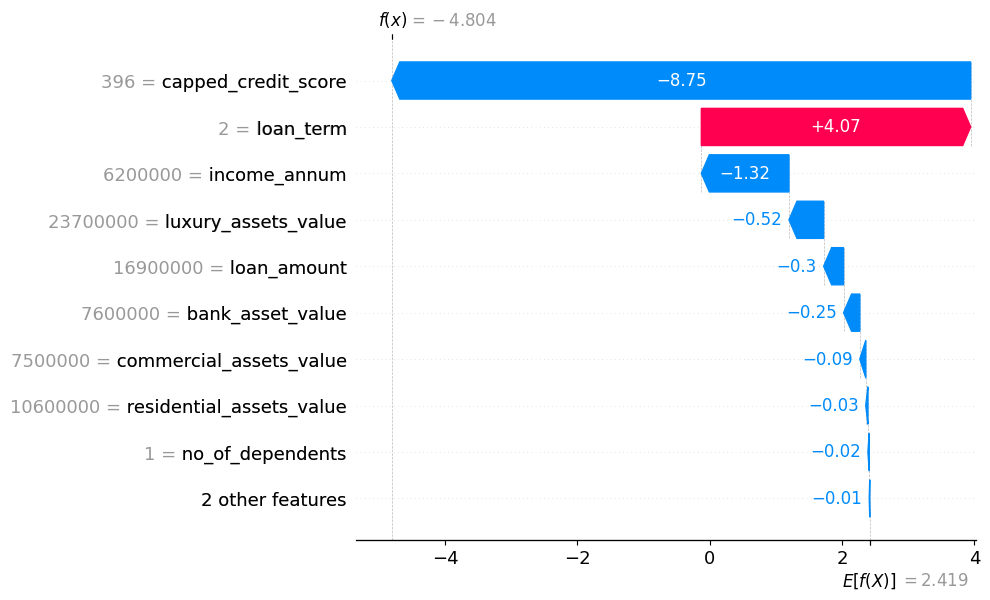

In [61]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[45])

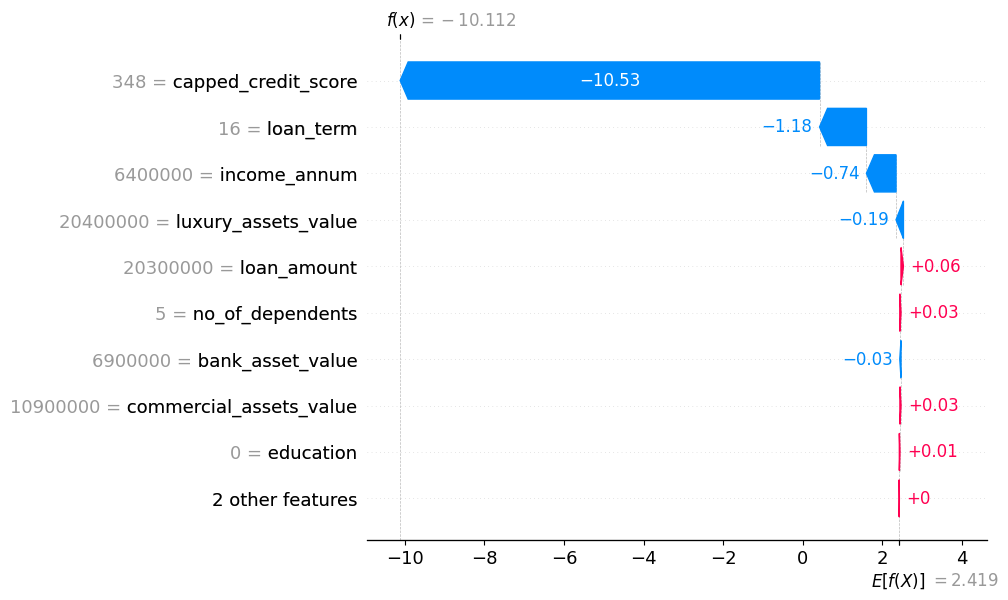

In [ ]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[1250])

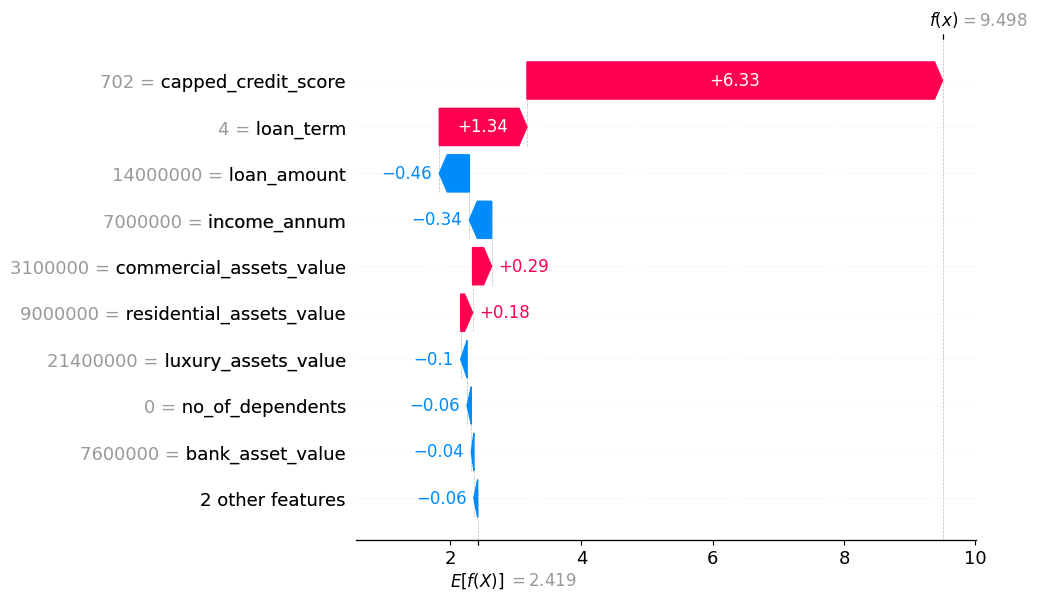

In [62]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[87])

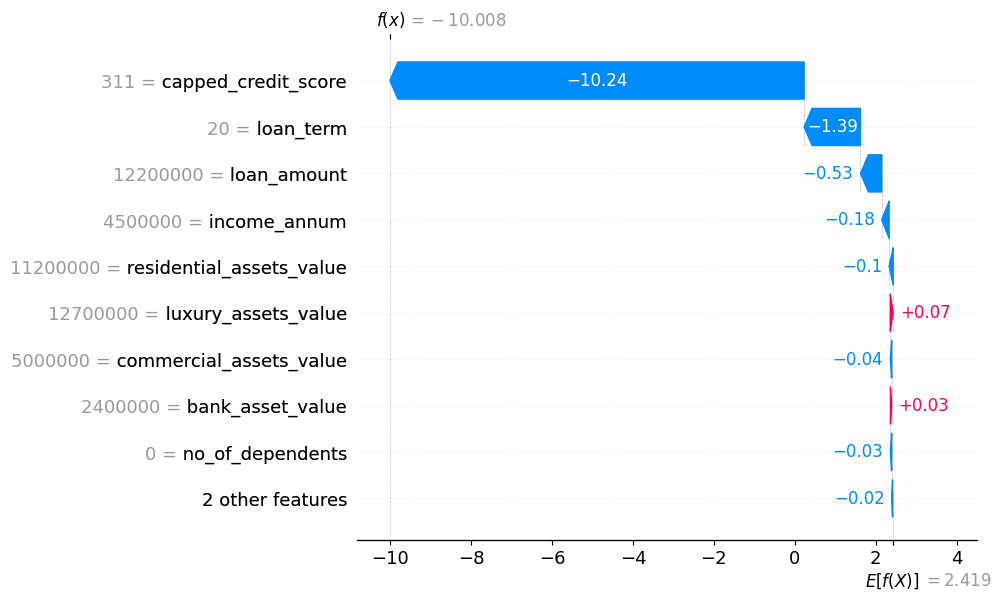

In [63]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[788])

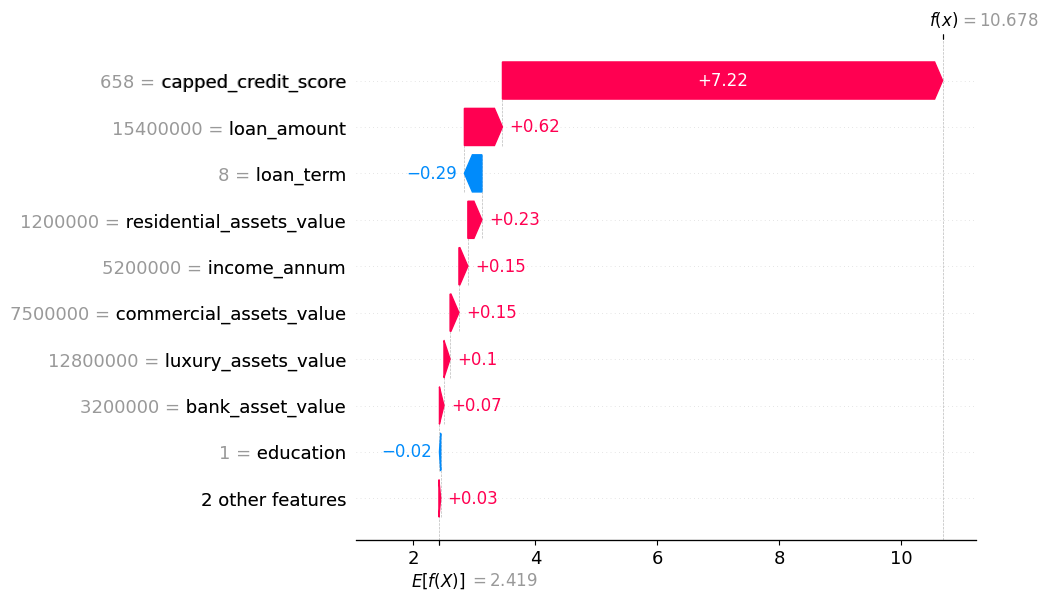

In [64]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[63])

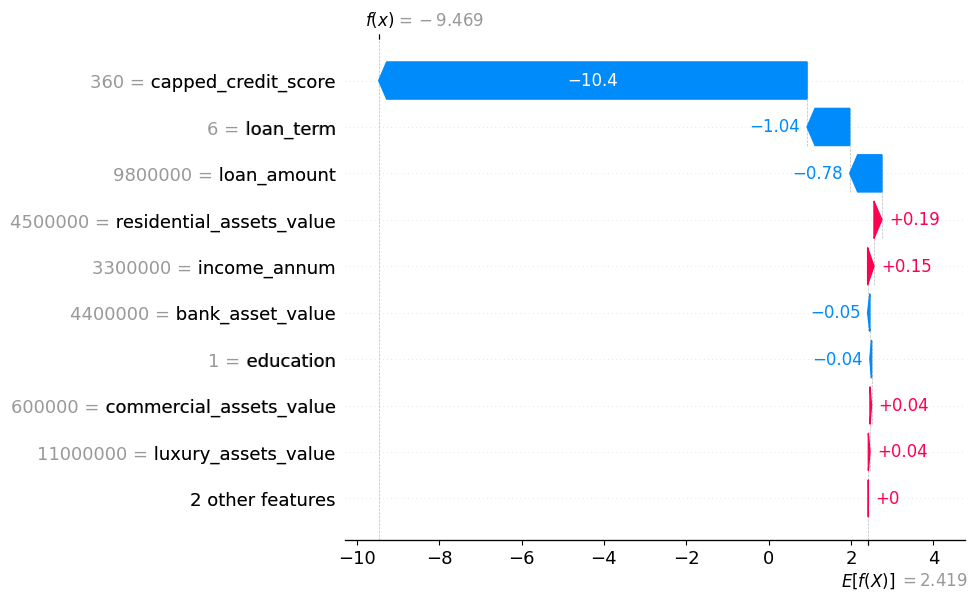

In [65]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[211])

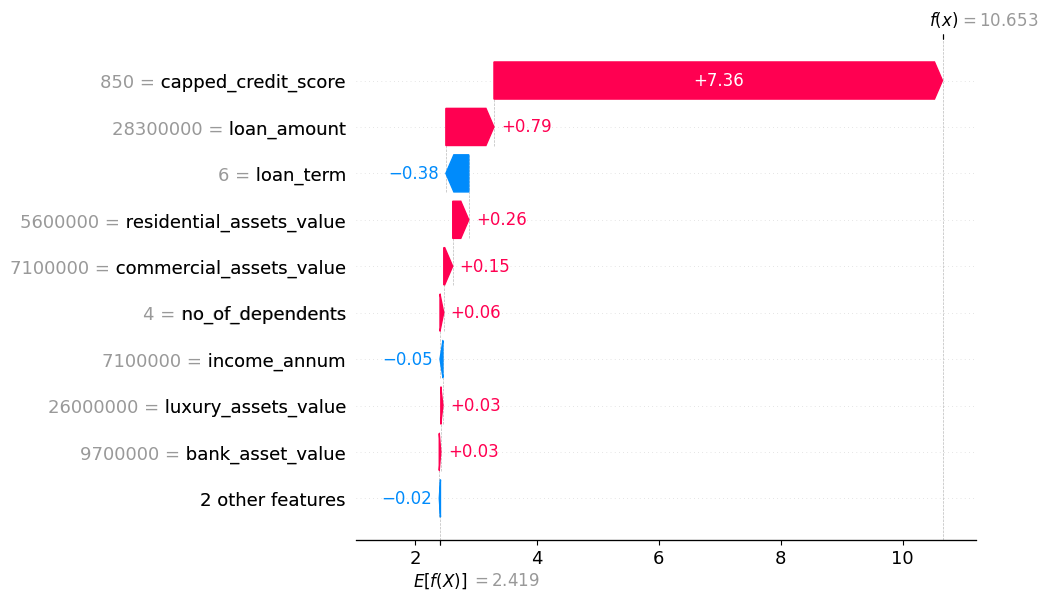

In [66]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[30])

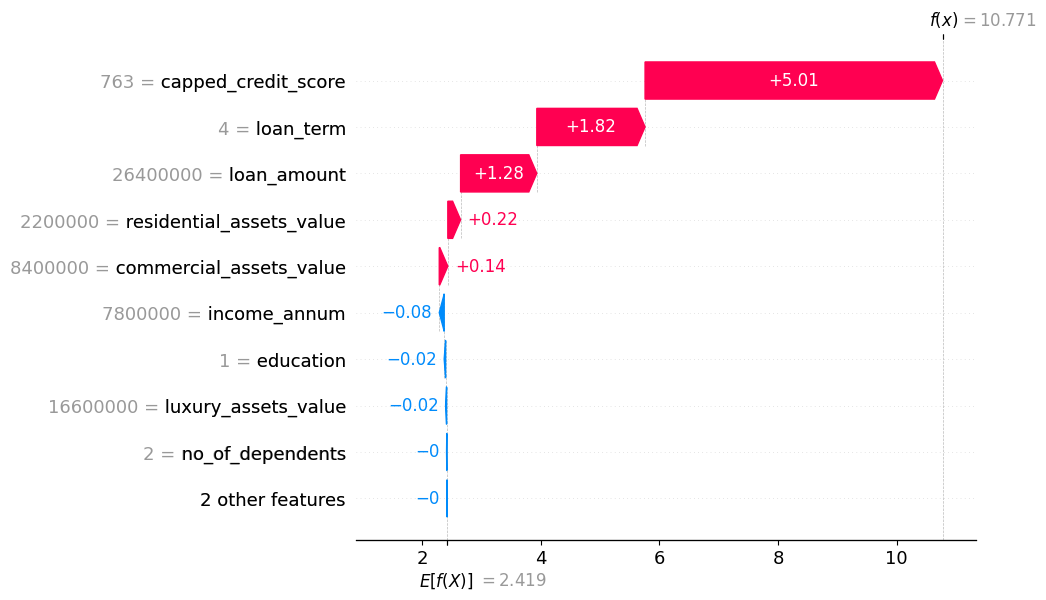

In [67]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[70])

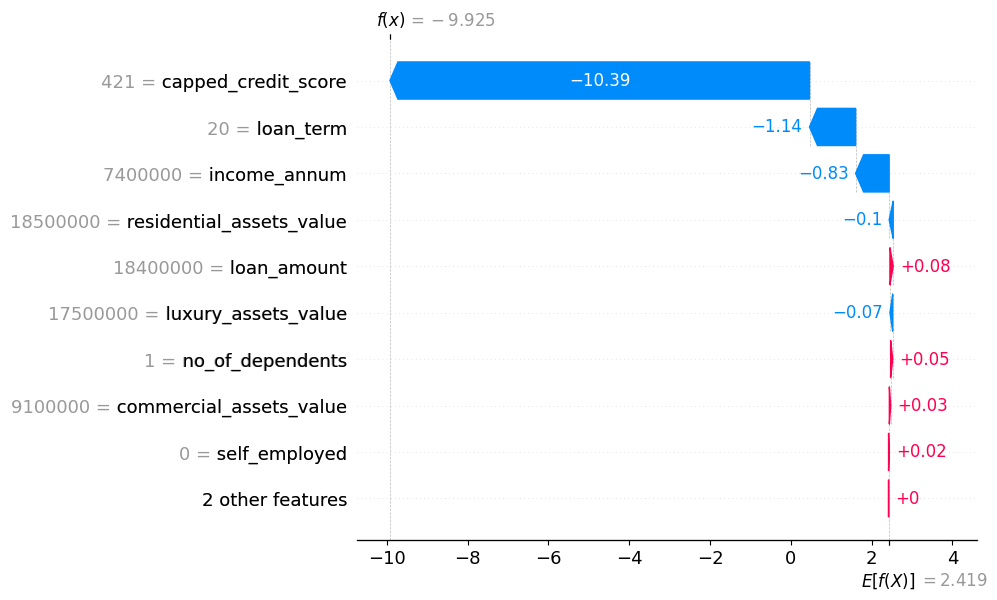

In [68]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[170])

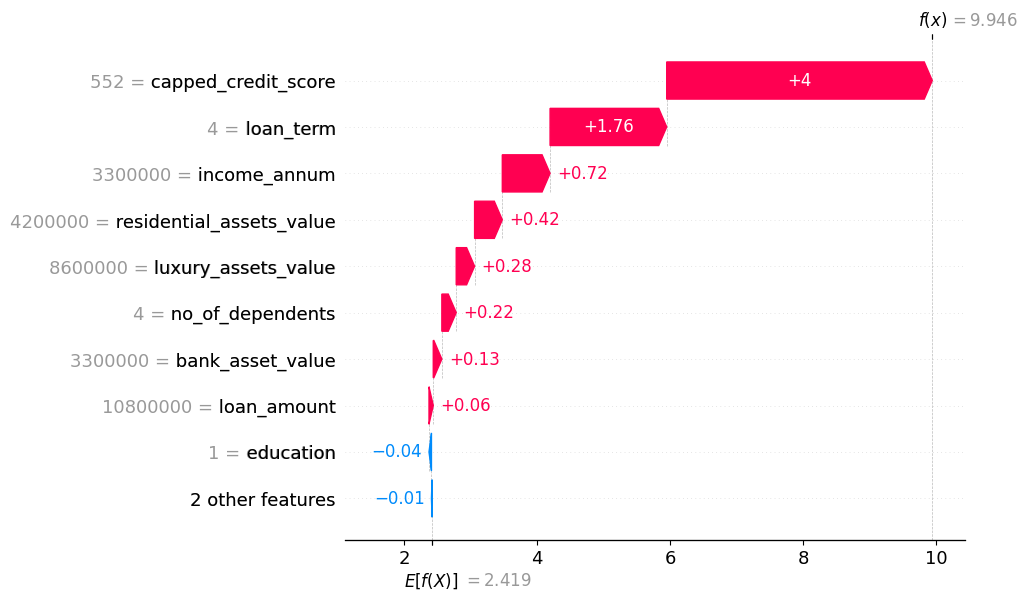

In [69]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[323])

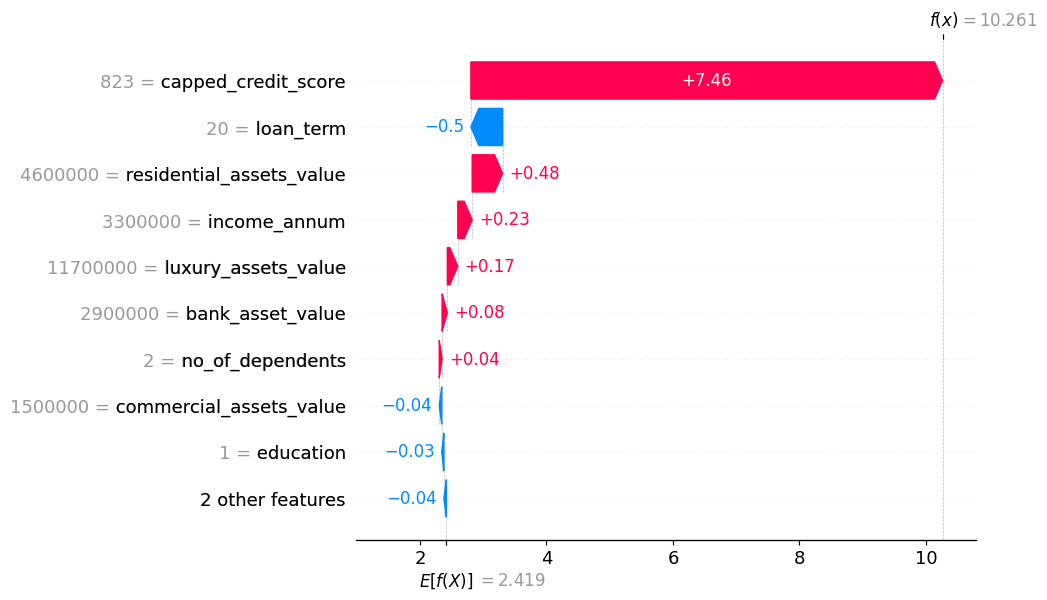

In [70]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[401])

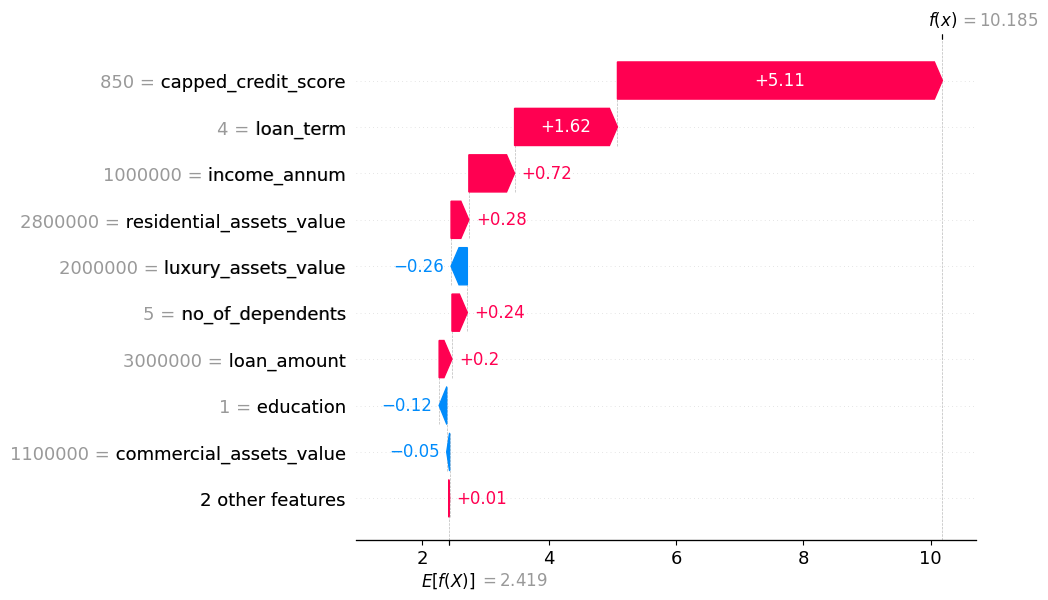

In [71]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[500])

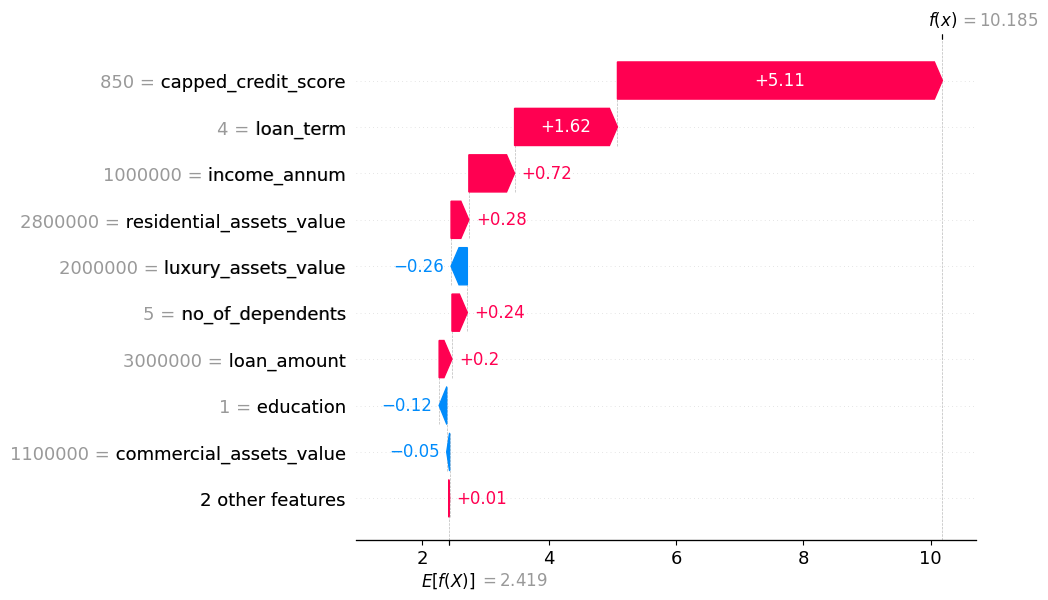

In [72]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[500])

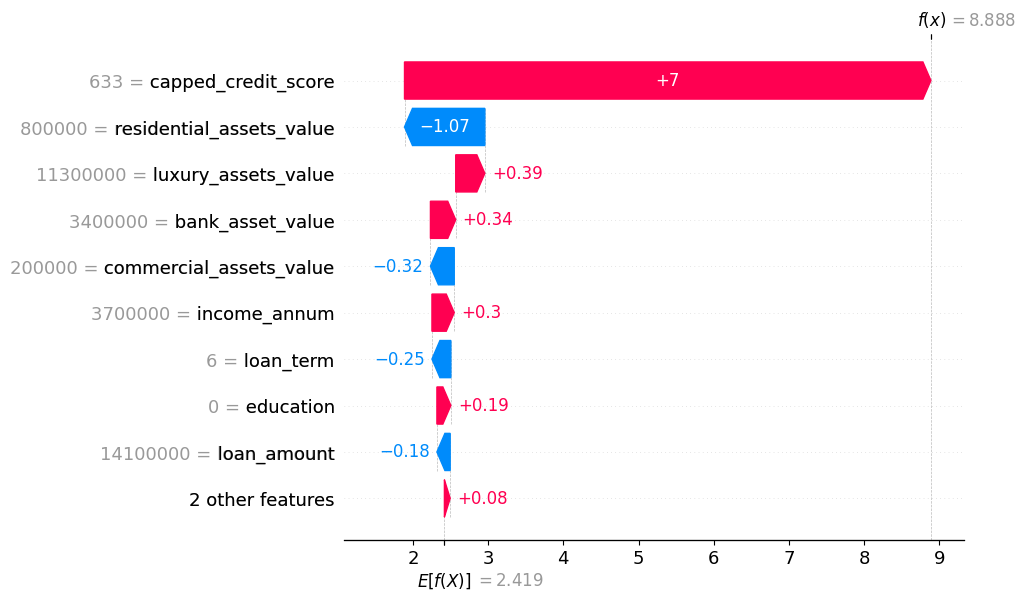

In [73]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[999])

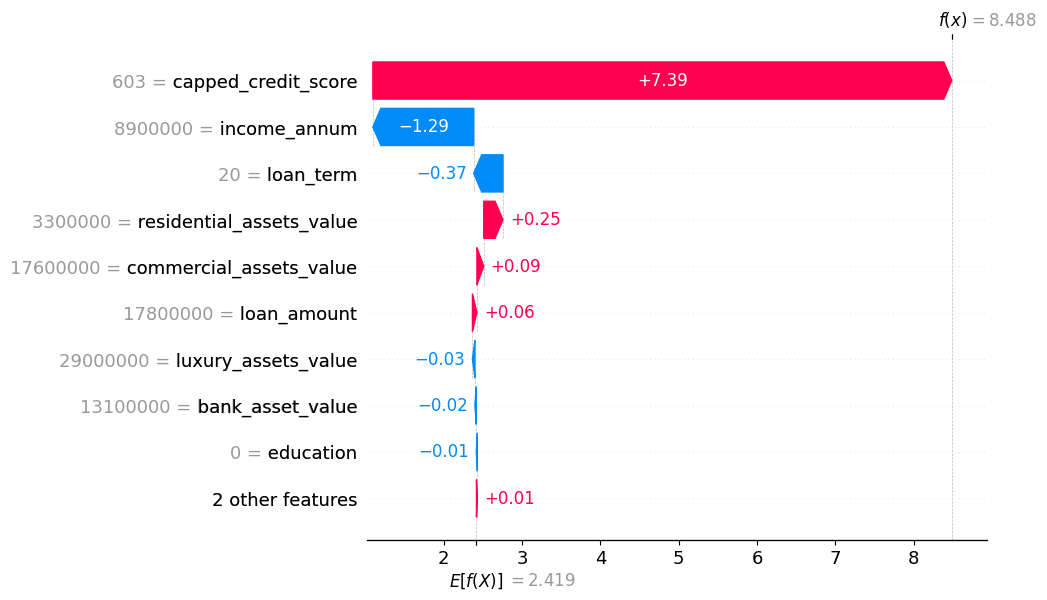

In [74]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[2242])

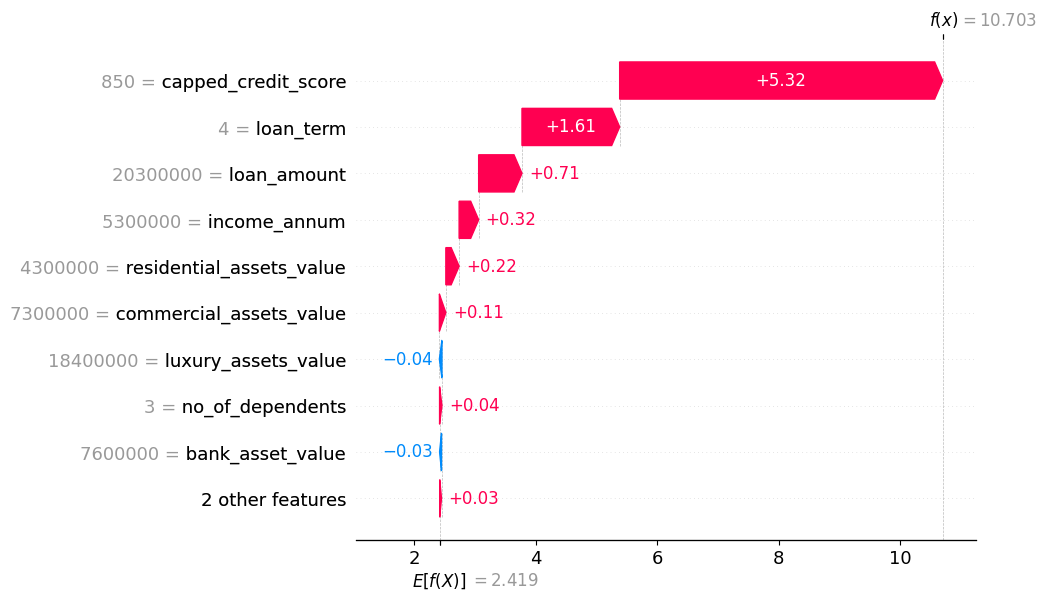

In [75]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[611])

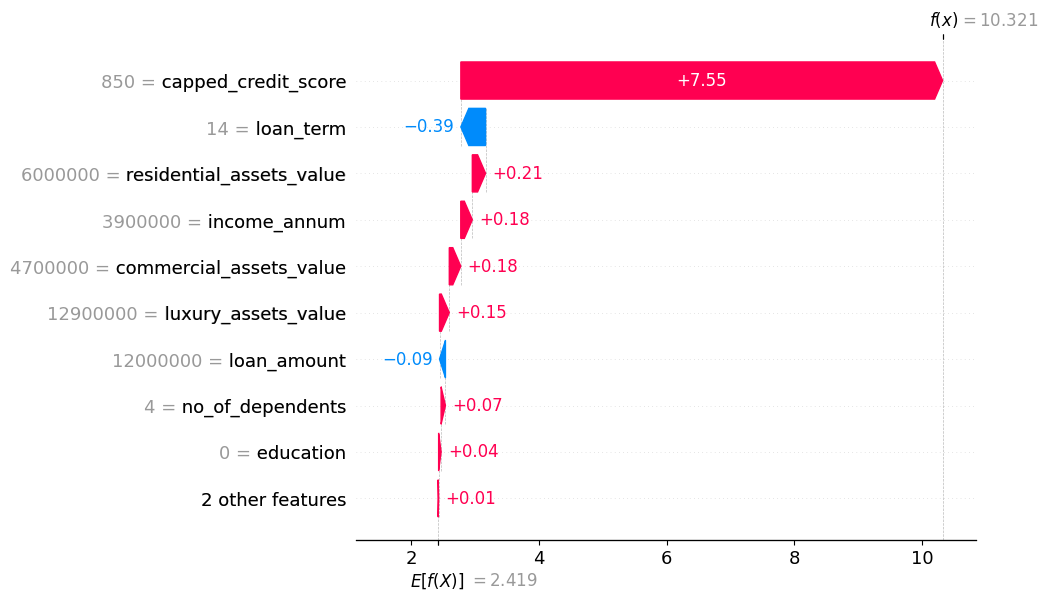

In [76]:
#Waterfall plot (Displays the SHAP values for the first instance, showing all features.)
shap.plots.waterfall(shap_values[1111])

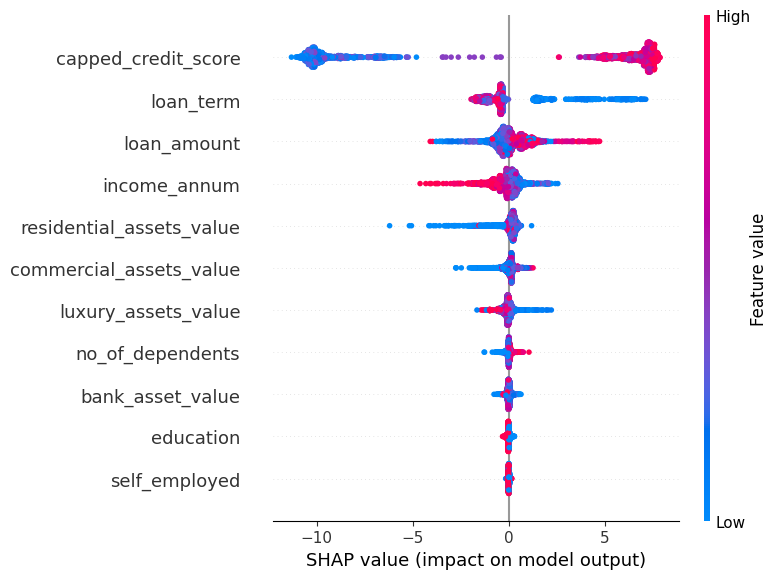

In [ ]:
shap.summary_plot(shap_values)

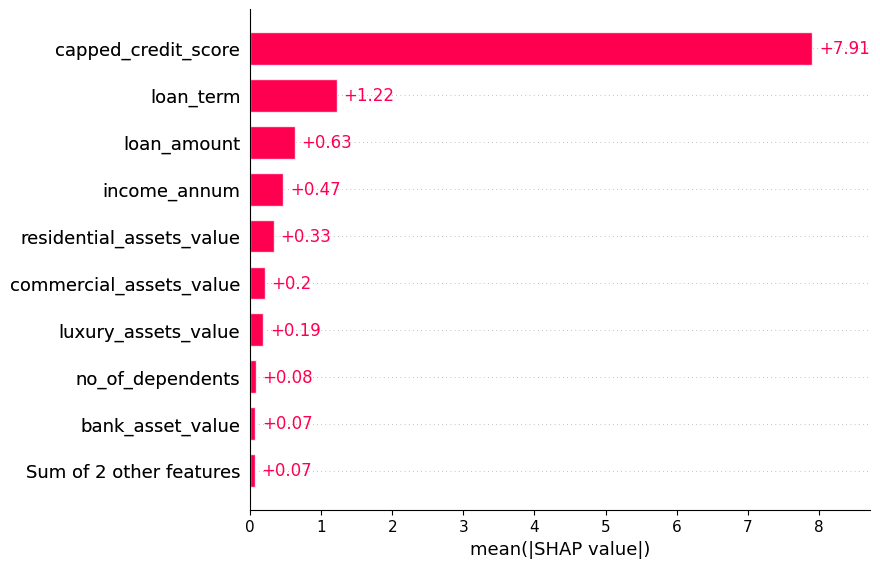

In [ ]:
#Absolute Mean SHAP
shap.plots.bar(shap_values)

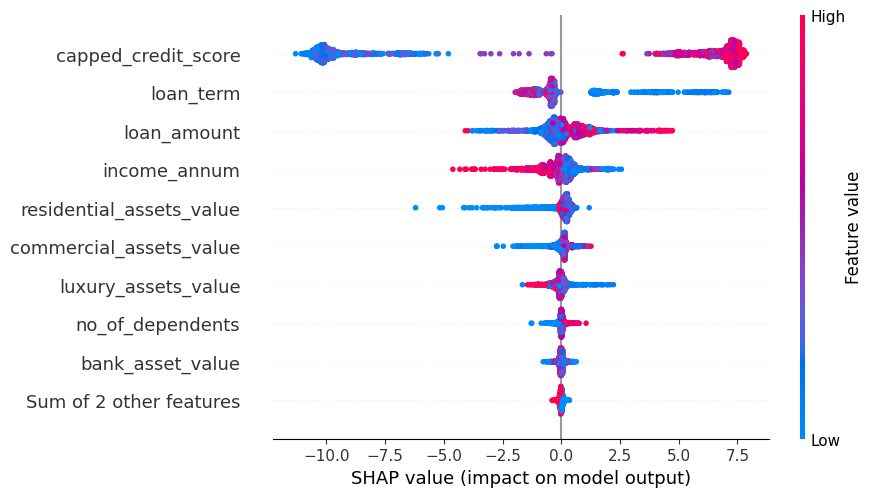

In [ ]:
#Beeswarm plot (most important)
shap.plots.beeswarm(shap_values)